# Telecommunications churn dataset
## Part 2 - best decision tree model
This notebook creates two decision tree models to predict customer churn. The first model will be a basic decision tree with default parameters and the second model will be a hyper-parameter tunned decision tree. The two models will be compared using various metrics.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import os
BASE_DIR = os.path.dirname(os.path.abspath('')) # define base directory
DATA_DIR = os.path.join(BASE_DIR, 'Data')
OUT_DIR = os.path.join(BASE_DIR, 'Output')

In [6]:
df = pd.read_csv(os.path.join(DATA_DIR, 'data_processed.csv'))
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,1,9,1,0,0,0,2,0,2,2,0,1,1,3,65.6,593.30,0
1,1,0,0,0,9,1,2,0,0,0,0,0,0,2,0,0,3,59.9,542.40,0
2,1,1,0,0,4,1,0,1,0,0,2,0,0,0,0,1,2,73.9,280.85,1
3,1,1,1,0,13,1,0,1,0,2,2,0,2,2,0,1,2,98.0,1237.85,1
4,0,1,1,0,3,1,0,1,0,0,0,2,2,0,0,1,3,83.9,267.40,1


In [3]:
X = df.drop("Churn", axis=1)  # df of everything except Churn column
y = df["Churn"] 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [5]:
# Function to print confusion matrix
def conf_matrix(target, target_pred):
    matrix = confusion_matrix(target, target_pred)

    sns.heatmap(data=matrix, annot=True, fmt=".0f", xticklabels = ["Churn no", "Churn yes"], yticklabels = ["Churn no", "Churn yes"], cmap="Blues")
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.title("Decision Tree Classifier")

In [6]:
def metrics(target, target_pred):
    return(classification_report(target, target_pred, target_names = ["Churn No", "Churn Yes"]))

### Models and Metrics

#### Metrics
Accuracy, recall, precision, and f1 score will be used to evaluate the models.
- A larger focus will be placed on predicting the Churn Yes class (1) as this is the minority class and will be harder to predict. This means to optimise for recall.
- A lower precision score should be allowed. More false positives can be addressed through business decisions, or may help identify customers at-rish of churnning.

#### Method
1. Use GridsearchCV to find the best parameters for a particular model on the training set.
2. Use cross_val_predict to make predictions on the test set and include metrics. Cross_val_predict gives us an idea of the spread/uncertainty of our model.

#### 1.1 Base Model Decision Tree

#### Method
1. Define model with default parameters, except random_state = 42 for reproducibility
2. Fit to training set
3. Predict test set
4. Show and evaluate metrics

In [7]:
dt_clf = DecisionTreeClassifier(random_state=42) 
dt_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 42,
 'splitter': 'best'}

In [8]:
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [17]:
y_pred = dt_clf.predict(X=X_test)

#### 1.2 Base Model Decision Tree metrics

In [12]:
# classification report from function above
print(metrics(y_test, y_pred))

              precision    recall  f1-score   support

    Churn No       0.85      0.84      0.84      1704
   Churn Yes       0.57      0.60      0.58       617

    accuracy                           0.77      2321
   macro avg       0.71      0.72      0.71      2321
weighted avg       0.78      0.77      0.78      2321



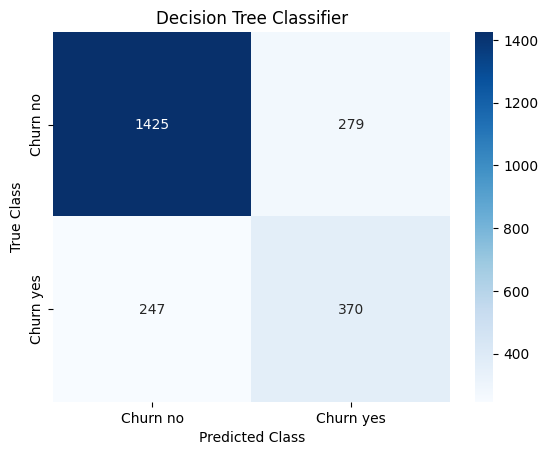

In [13]:
# Confusion Matrix - from function above
conf_matrix(y_test, y_pred)

In [22]:
roc_auc_score(y_test, y_pred)

0.7179717282626065

#### 2.1 Gridsearch 5-fold - CV search model Decision Tree

In [14]:
# Hyperprameter tuning - Gridsearch
# Computes 5-fold CV for every single model and takes best mean 'scoring' which will be roc_auc.
params =[ {'max_depth' : list(range(1,11)), 'min_samples_leaf' : [30,40,50,60,70,80], 'min_samples_split': [1,2,3,4,5,8]}]
dt_model = DecisionTreeClassifier(random_state=42)
gridsearch = GridSearchCV(dt_model, params, cv=5, n_jobs=-1, scoring = 'accuracy', verbose=2)
gridsearch.fit(X_train, y_train)


Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:   13.2s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'min_samples_leaf': [30, 40, 50, 60, 70, 80],
                          'min_samples_split': [1, 2, 3, 4, 5, 8]}],
             scoring='accuracy', verbose=2)

In [15]:
gridsearch.best_estimator_

DecisionTreeClassifier(max_depth=7, min_samples_leaf=40, random_state=42)

In [16]:
best_model = gridsearch.best_estimator_

#### 2.2 Hyperparameter search model Decision Tree metrics

In [35]:
#y_pred2 = cross_val_predict(estimator=best_model, X=X_test, y=y_test, cv=5)
y_pred2 = best_model.predict(X_test)
cross_val_scores2 = cross_val_score(estimator=best_model, X=X_test, y=y_test, cv=5, scoring="roc_auc")
print(f"Average ROC AUC score across 5-fold-CV: {cross_val_scores2.mean().round(decimals=2)}")

Average ROC AUC score across 5-fold-CV: 0.88


In [24]:
print(metrics(y_test, y_pred2))

              precision    recall  f1-score   support

    Churn No       0.88      0.92      0.90      1704
   Churn Yes       0.76      0.67      0.71       617

    accuracy                           0.85      2321
   macro avg       0.82      0.80      0.81      2321
weighted avg       0.85      0.85      0.85      2321



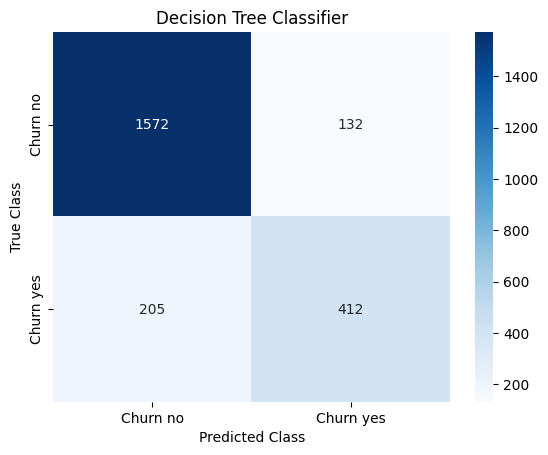

In [25]:
conf_matrix(y_test, y_pred2)

In [26]:
roc_auc_score(y_test, y_pred2)

0.7951411874814528

### 2.3 Plot tree for best single decision tree model

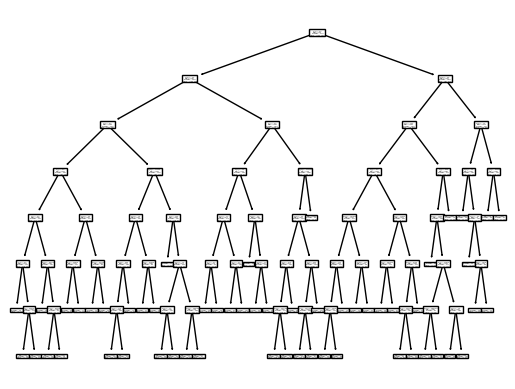

In [27]:
plot_tree(best_model)
plt.show()

#### 3.0 Decision Tree Bagging

In [28]:
from sklearn.ensemble import BaggingClassifier

In [29]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_depth=5, random_state=42), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1, oob_score=True)

# Can't add min_smaples_leaf='' into the DecisionTree model - gives 0 precision/recall on Churn Yes

In [30]:
bag_clf.fit(X, y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                        random_state=42),
                  max_samples=100, n_estimators=500, n_jobs=-1, oob_score=True)

In [31]:
y_pred5=bag_clf.predict(X_test)

In [32]:
print(metrics(y_test, y_pred5))

              precision    recall  f1-score   support

    Churn No       0.88      0.93      0.91      1704
   Churn Yes       0.78      0.65      0.71       617

    accuracy                           0.86      2321
   macro avg       0.83      0.79      0.81      2321
weighted avg       0.85      0.86      0.85      2321



In [33]:
bag_clf.oob_score_

0.8603526734926052

In [34]:
roc_auc_score(y_test, y_pred5)

0.7931295226790239